In [4]:
import h5py
import numpy as np
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import nibabel as nib
import pandas as pd
from IPython.display import clear_output
import importlib
import napari
from skimage import morphology
from skimage.measure import regionprops, regionprops_table
from skimage.morphology import disk, binary_dilation


In [5]:
sys.path.insert(1, "/Users/dvarelat/Documents/MASTER/TFM/methods")
import cardiac_region
importlib.reload(cardiac_region)
import cardiac_region as c

In [12]:
ESPECIMEN = "20190504_E1"

In [13]:
CC = f"/Users/dvarelat/Documents/MASTER/TFM/DATA/CardiacRegion/{ESPECIMEN}/{ESPECIMEN}_mGFP_CardiacRegion_0.5.nii.gz"
gasp = f"/Users/dvarelat/Documents/MASTER/TFM/DATA/RESULTS/membranes/GASP_PNAS/{ESPECIMEN}_mGFP_CardiacRegion_0.5_XYZ_predictions_GASP.nii.gz"
linefile = F"/Users/dvarelat/Documents/MASTER/TFM/DATA/LINES/line_{ESPECIMEN}.nii.gz"
decon = f"/Users/dvarelat/Documents/MASTER/TFM/DATA/DECON_05/MGFP/{ESPECIMEN}_mGFP_decon_0.5.nii.gz"

In [8]:
os.path.isfile(decon)

True

In [8]:
lines = nib.load(linefile).get_fdata()
lines.shape

(1024, 1024, 463)

## cut lines file

In [9]:
pred_mem = nib.load(gasp).get_fdata()
pred_mem.shape

FileNotFoundError: No such file or no access: '/Users/dvarelat/Documents/MASTER/TFM/DATA/RESULTS/membranes/GASP_PNAS/20190119_E1_mGFP_CardiacRegion_0.5_XYZ_predictions_GASP.nii.gz'

In [11]:
c.load3D_metadata(linefile)

{'x_size': 1024,
 'y_size': 1024,
 'z_size': 566,
 'x_res': 0.853671,
 'y_res': 0.853671,
 'z_res': 0.99691}

In [12]:
c.load3D_metadata(gasp)

{'x_size': 881,
 'y_size': 900,
 'z_size': 480,
 'x_res': 0.853671,
 'y_res': 0.853671,
 'z_res': 0.99691}

In [85]:
c.load3D_metadata(decon05_cc)

{'x_size': 877,
 'y_size': 829,
 'z_size': 526,
 'x_res': 1.0,
 'y_res': 1.0,
 'z_res': 1.0}

In [14]:
margenes = c.crop_line(linefile, linefile, escala2048=False, ma=10)

MARGIN : 10
Line information
{'x_size': 1024, 'y_size': 1024, 'z_size': 413, 'x_res': 0.757206, 'y_res': 0.757206, 'z_res': 0.995703}
LINE SHAPE = (1024, 1024, 413)
SCALING WITH DECON 05 --> 1024
{'x_size': 1024, 'y_size': 1024, 'z_size': 413, 'x_res': 0.757206, 'y_res': 0.757206, 'z_res': 0.995703}


In [15]:
margenes

(array([210,  40,  18]), array([764, 895, 256]))

In [14]:
cut_lines = c.crop_embryo(margenes, linefile)

CROP SHAPE = (881, 900, 480)


In [15]:
FILE = f"/Users/dvarelat/Documents/MASTER/TFM/DATA/LINES/CC/line_{ESPECIMEN}_CC.nii.gz"
ni_img = nib.Nifti1Image(cut_lines.astype('uint16'), affine=np.eye(4))
nib.save(ni_img, FILE)

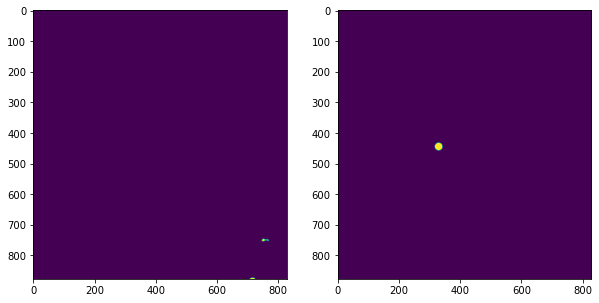

In [10]:
for t in range(52):
    plt.figure(figsize=(10,10)) 
    n = 10*t
    plots = [pred_mem[:, :, n],cut_lines[:,:,n]]
    for i in range(len(plots)):
        plt.subplot(1,len(plots), i+1)
        plt.imshow(plots[i])
    plt.show()
    clear_output(wait=True)

In [11]:
np.unique(cut_lines)

array([ 0.,  1.,  4.,  5.,  6.,  9., 10., 11., 12.])

In [12]:
img_labels = morphology.label(pred_mem, return_num=False)
img_labels.shape

(877, 829, 526)

In [13]:
props = regionprops(img_labels)

In [14]:
len(props)

11570

In [15]:
centroids = [p["centroid"] for p in props]
centroids_int = [[round(i) for i in c] for c in centroids]

In [16]:
pred_mem.shape 

(877, 829, 526)

In [30]:
centros = np.zeros(pred_mem.shape)
centros.shape

(877, 829, 526)

In [29]:
len(centroids_int)

11570

In [31]:
for c in centroids_int:
    centros[c[0]-1,c[1]-1, c[2]-1] = 1

In [42]:
centros = binary_dilation(centros, footprint=morphology.cube(4))

In [ ]:
for t in range(52):
    plt.figure(figsize=(10,10)) 
    n = 10*t
    plots = [centros[:, :, n]]
    for i in range(len(plots)):
        plt.subplot(1,len(plots), i+1)
        plt.imshow(plots[i])
    plt.show()
    clear_output(wait=True)

In [70]:
labels_lines = [cut_lines[c[0],c[1],c[2]] for c in centroids_int]

In [71]:
len(labels_lines)

11570

In [51]:
dict_labels_lines = dict(zip([p.label for p in props], labels_lines))
dict_centroid_lines = dict(zip([p.label for p in props], centroids_int))

In [53]:
colors_lines = np.zeros(pred_mem.shape)
colors_lines.shape

(877, 829, 526)

In [ ]:
#cells_mask = np.isin(test_array, labels)

In [72]:
copyprops = props.copy()
copyarray = pred_mem.copy()

In [66]:
for i,p in enumerate(copyprops):
    p.label = dict_labels_lines[i+1]

In [78]:
for i in range(len(props)):
    #copyarray = np.where(copyarray == i+1, labels_lines[i], copyarray) 
    copyarray[copyarray == i+1] = labels_lines[i]

KeyboardInterrupt: 

## VISUALIZATION

In [20]:
#viewer = napari.view_image(np.swapaxes(np.swapaxes(pred_mem, 0, 2), 1, 2))

In [21]:
#viewer.add_image(np.swapaxes(np.swapaxes(cut_lines, 0, 2), 1, 2), name='lines')

In [2]:
import os

In [6]:
for j in [i.replace("line_", "").replace(".nii.gz", "") for i in os.listdir("/Users/dvarelat/Documents/MASTER/TFM") if "line" in i]:
    print(j)

20190404_E2
20190520_E4
20190516_E3
20190806_E3
20190520_E2
20190401_E1
20190401_E3
20190517_E1
20190520_E1


In [7]:
[i.replace("line_", "").replace(".nii.gz", "") for i in os.listdir("/Users/dvarelat/Documents/MASTER/TFM") if "line" in i]

['20190404_E2',
 '20190520_E4',
 '20190516_E3',
 '20190806_E3',
 '20190520_E2',
 '20190401_E1',
 '20190401_E3',
 '20190517_E1',
 '20190520_E1']

In [22]:
#l

In [23]:
#dict_lines = dict(zip(labels, labels_lines))

In [24]:
#dict_lines

In [1]:
1000/60

16.666666666666668